In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 6)

%matplotlib inline

import redis

cache_ip = '198.13.60.78'
cache_pw = 'da56038fa453c22d2c46e83179126e97d4d272d02ece83eb83a97357e842d065'

r = redis.StrictRedis(host=cache_ip, port=6379, password=cache_pw)

# redis keys
KOSPI_INDEX = 'I.001_INDEX'

KOSPI_TICKERS = 'KOSPI_TICKERS'
KOSDAQ_TICKERS = 'KOSDAQ_TICKERS'

KOSPI_OHLCV = 'KOSPI_OHLCV'
KOSDAQ_OHLCV = 'KOSDAQ_OHLCV'

KOSPI_VOL = 'KOSPI_VOL'
KOSDAQ_VOL = 'KOSDAQ_VOL'

kp_tickers = [ticker.decode() for ticker in r.lrange(KOSPI_TICKERS, 0 ,-1)]
kd_tickers = [ticker.decode() for ticker in r.lrange(KOSDAQ_TICKERS, 0 ,-1)]
tickers = kp_tickers + kd_tickers

In [2]:
DATA_MAPPER = {
    'index_tickers': 'INDEX_TICKERS',
    'kospi_tickers': 'KOSPI_TICKERS',
    'kosdaq_tickers': 'KOSDAQ_TICKERS',
    'kospi_ohlcv': 'KOSPI_OHLCV',
    'kospi_vol': 'KOSPI_VOL',
    'kosdaq_ohlcv': 'KOSDAQ_OHLCV',
    'kosdaq_vol': 'KOSDAQ_VOL',
    'index': '_INDEX',
    'ohlcv': '_OHLCV'
}

MARKET_CODES = {
    # 시장 인덱스
    '코스피': 'I.001',
    '코스닥': 'I.201',

    # 사이즈 인덱스
    '코스피 대형주': 'I.002',
    '코스피 중형주': 'I.003',
    '코스피 소형주': 'I.004',
    '코스닥 대형주': 'I.202',
    '코스닥 중형주': 'I.203',
    '코스닥 소형주': 'I.204',

    # 스타일 인덱스
    '성장주': 'I.431',  # KRX 스마트 모멘텀
    '가치주': 'I.432',  # KRX 스마트 밸류
    '배당주': 'I.192',  # KRX 고배당 50
    '퀄리티주': 'I.433',  # KRX 스마트 퀄리티
    '사회책임경영주': 'I.426',  # KRX 사회책임경영

    # 산업 인덱스
    '코스피 음식료품': 'I.005',
    '코스피 섬유,의복': 'I.006',
    '코스피 종이,목재': 'I.007',
    '코스피 화학': 'I.008',
    '코스피 의약품': 'I.009',
    '코스피 비금속광물': 'I.010',
    '코스피 철강및금속': 'I.011',
    '코스피 기계': 'I.012',
    '코스피 전기,전자': 'I.013',
    '코스피 의료정밀': 'I.014',
    '코스피 운수장비': 'I.015',
    '코스피 유통업': 'I.016',
    '코스피 전기가스업': 'I.017',
    '코스피 건설업': 'I.018',
    '코스피 운수창고': 'I.019',
    '코스피 통신업': 'I.020',
    '코스피 금융업': 'I.021',
    '코스피 은행': 'I.022',
    '코스피 증권': 'I.024',
    '코스피 보험': 'I.025',
    '코스피 서비스업': 'I.026',
    '코스피 제조업': 'I.027',
    '코스닥 기타서비스': 'I.212',
    '코스닥 IT종합': 'I.215',
    '코스닥 제조': 'I.224',
    '코스닥 건설': 'I.226',
    '코스닥 유통': 'I.227',
    '코스닥 운송': 'I.229',
    '코스닥 금융': 'I.231',
    '코스닥 오락, 문화': 'I.237',
    '코스닥 통신방송서비스': 'I.241',
    '코스닥 IT S/W & SVC': 'I.242',
    '코스닥 IT H/W': 'I.243',
    '코스닥 음식료,담배': 'I.256',
    '코스닥 섬유,의류': 'I.258',
    '코스닥 종이,목재': 'I.262',
    '코스닥 출판,매체복제': 'I.263',
    '코스닥 화학': 'I.265',
    '코스닥 제약': 'I.266',
    '코스닥 비금속': 'I.267',
    '코스닥 금속': 'I.268',
    '코스닥 기계,장비': 'I.270',
    '코스닥 일반전기,전자': 'I.272',
    '코스닥 의료,정밀기기': 'I.274',
    '코스닥 운송장비,부품': 'I.275',
    '코스닥 기타 제조': 'I.277',
    '코스닥 통신서비스': 'I.351',
    '코스닥 방송서비스': 'I.352',
    '코스닥 인터넷': 'I.353',
    '코스닥 디지탈컨텐츠': 'I.354',
    '코스닥 소프트웨어': 'I.355',
    '코스닥 컴퓨터서비스': 'I.356',
    '코스닥 통신장비': 'I.357',
    '코스닥 정보기기': 'I.358',
    '코스닥 반도체': 'I.359',
    '코스닥 IT부품': 'I.360'
}

In [3]:
def get_val(redis_client, key):
    ## mined에서 사용하게 될 모든 데이터는 TICKERS 데이터가 아니면 pandas df이다
    ## TICKERS 데이터는 리스트 형식이다
    if 'TICKERS' in key:
        data = redis_client.lrange(key, 0, -1)
        data = list(map(lambda x: x.decode('utf-8'), data))
    else:
        data = pd.read_msgpack(redis_client.get(key))  # 레디스에서 df 형식의 데이터를 가지고 오는 방법
        ### 참고: 레디스에 df를 저장하는 방법은: redis.set(key, df.to_msgpack(compress='zlib'))와 같은 형식이다
    return data

In [4]:
def set_index_lists():
    index_list = MARKET_CODES.keys()  # 인덱스 종류를 담은 리스트

    # 모든 인덱스 종류를 담은 리스트 만들기
    # 산업별 분류는 너무 많아서 나머지 리스트에서 없는 인덱스를 가져오는 방식으로 리스트 정의
    bm = ['코스피', '코스닥']
    size = ['코스피 대형주', '코스피 중형주', '코스피 소형주', '코스닥 대형주', '코스닥 중형주', '코스닥 소형주']
    style = ['성장주', '가치주', '배당주', '퀄리티주', '사회책임경영주']
    industry = [index for index in index_list if index not in bm and \
                     index not in size and \
                     index not in style]

    print('BM: ' + ' '.join(str(i) for i in bm))
    print('SIZE: ' + ' '.join(str(i) for i in size))
    print('STYLE: ' + ' '.join(str(i) for i in style))
    print('INDUSTRY: ' + ' '.join(str(i) for i in industry))
    
    return bm, size, style, industry

In [5]:
def make_index_data(redis_client, index_list):
    index_data_dict = {}  # 딕셔너리 형식으로 저장한다

    for index in index_list:
        # 레디스 키값은 I.002_INDEX와 같은 형식이다
        index_key = MARKET_CODES[index] + DATA_MAPPER['index']  # MARKET_CODES 딕셔너리에서 코드를 찾아온다
        index_df = get_val(redis_client, index_key)
        index_data_dict[index] = index_df
    return index_data_dict

In [6]:
bm, size, style, industry = set_index_lists()

bm_data = make_index_data(r, bm)
size_data = make_index_data(r, size)
style_data = make_index_data(r, style)
industry_data = make_index_data(r, industry)

index_keys = bm + size + style + industry

make_data_start = True

for key in index_keys:
    
    if key in bm:
        data = bm_data
    if key in size:
        data = size_data
    if key in style:
        data = style_data
    if key in industry:
        data = industry_data
        
    ohlcv_df = data[key][['date', 'cls_prc']]
    ohlcv_df.set_index('date', inplace=True)
    ohlcv_df.rename(columns={'cls_prc': key}, inplace=True)
    
    vol_df = data[key][['date', 'trd_qty']]
    vol_df.set_index('date', inplace=True)
    vol_df.rename(columns={'trd_qty': key}, inplace=True)
    
    if make_data_start:
        index_ohlcv = ohlcv_df
        index_vol = vol_df
        make_data_start = False
    else:
        index_ohlcv = pd.concat([index_ohlcv, ohlcv_df], axis=1, sort=True)
        index_vol = pd.concat([index_vol, vol_df], axis=1, sort=True)

BM: 코스피 코스닥
SIZE: 코스피 대형주 코스피 중형주 코스피 소형주 코스닥 대형주 코스닥 중형주 코스닥 소형주
STYLE: 성장주 가치주 배당주 퀄리티주 사회책임경영주
INDUSTRY: 코스피 음식료품 코스피 섬유,의복 코스피 종이,목재 코스피 화학 코스피 의약품 코스피 비금속광물 코스피 철강및금속 코스피 기계 코스피 전기,전자 코스피 의료정밀 코스피 운수장비 코스피 유통업 코스피 전기가스업 코스피 건설업 코스피 운수창고 코스피 통신업 코스피 금융업 코스피 은행 코스피 증권 코스피 보험 코스피 서비스업 코스피 제조업 코스닥 기타서비스 코스닥 IT종합 코스닥 제조 코스닥 건설 코스닥 유통 코스닥 운송 코스닥 금융 코스닥 오락, 문화 코스닥 통신방송서비스 코스닥 IT S/W & SVC 코스닥 IT H/W 코스닥 음식료,담배 코스닥 섬유,의류 코스닥 종이,목재 코스닥 출판,매체복제 코스닥 화학 코스닥 제약 코스닥 비금속 코스닥 금속 코스닥 기계,장비 코스닥 일반전기,전자 코스닥 의료,정밀기기 코스닥 운송장비,부품 코스닥 기타 제조 코스닥 통신서비스 코스닥 방송서비스 코스닥 인터넷 코스닥 디지탈컨텐츠 코스닥 소프트웨어 코스닥 컴퓨터서비스 코스닥 통신장비 코스닥 정보기기 코스닥 반도체 코스닥 IT부품


/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [7]:
len(tickers)

2759

In [8]:
# 종가/거래량 데이터 불러오기
kp_ohlcv = pd.read_msgpack(r.get(KOSPI_OHLCV))
kd_ohlcv = pd.read_msgpack(r.get(KOSDAQ_OHLCV))

kp_vol = pd.read_msgpack(r.get(KOSPI_VOL))
kd_vol = pd.read_msgpack(r.get(KOSDAQ_VOL))

In [9]:
# 거래대금 데이터 만들기
kp_vol_prc = kp_ohlcv * kp_vol
kd_vol_prc = kd_ohlcv * kd_vol
index_vol_prc = index_ohlcv * index_vol

In [10]:
# 수익률 데이터 만들기
kp_ret = kp_ohlcv.pct_change()
kd_ret = kd_ohlcv.pct_change()
index_ret = index_ohlcv.pct_change()

In [11]:
# 모든 OHLCV, Volume, Return 데이터를 하나로 묶는다
ohlcv = pd.concat([kp_ohlcv, kd_ohlcv, index_ohlcv], axis=1, sort=True)
volume = pd.concat([kp_vol, kd_vol, index_vol], axis=1, sort=True)
vol_prc = pd.concat([kp_vol_prc, kd_vol_prc, index_vol_prc], axis=1, sort=True)
returns = pd.concat([kp_ret, kd_ret, index_ret], axis=1, sort=True)

In [12]:
def set_periodic_close(ohlcv_df, period='M'):
    ### 인자 설명:
    ### 1. ohlcv_df (pd.DataFrame)
    ### 2. period (str) --> W, M, Q, 6M, A
    ###                     일주일, 한달, 세달, 여섯달, 일년 주기 종가

    # 인자로 받은 데이터프레임 ohlcv_df의 인덱스를 데이트타임으로 바꿔준다
    ohlcv_df.index = pd.to_datetime(ohlcv_df.index)
    periodic_close = ohlcv_df.resample(
        period).last()  # reference: http://benalexkeen.com/resampling-time-series-data-with-pandas/
    periodic_close.dropna(how='all', inplace=True)
    return periodic_close

In [13]:
def dual_momentum(data):
    # data (pd.DataFrame) --> 한 달을 주기로 resample된 데이터프레임
    # resample 처리가 안 된 상태라면, set_periodic_close() 메소드 사용
    for i in range(1, 13):
        momentum = (data - data.shift(i)) / data.shift(i)  # 단순 수익률: (P(t) - P(t-i))/P(t-i), P = 종가
        if i == 1:
            temp = momentum
        else:
            temp += momentum
    mom = temp / 12  # 위에서 구한 모든 모멘텀값을 더한 후 12로 나눔 (12개월 평균 모멘텀이 된다)
    return mom.fillna(0)  # nan은 0으로 처리

In [14]:
def volatility(returns_data, window=12):
    # 변동성 계산
    # 보통 변동성 계산은 일년을 주기로 계산한다
    # 그래서 returns_data 월별로 resample된거라면 window를 12로 잡는다
    # (데이터가 일일 데이터면 보통 window를 200으로 잡는다)
    # (데이터가 일주일로 resample되었다면, window는 48을 잡는다)
    # (3개월/분기별로 resample 되었다면 window는 4로 잡는다)
    return returns_data.rolling(window=window).std().fillna(0)

In [15]:
ohlcv_m = set_periodic_close(ohlcv, 'M')

momentum = dual_momentum(ohlcv_m)
risk = volatility(returns, 200)

In [16]:
momentum_score = ((momentum.T.rank(ascending=True)) / momentum.T.rank(ascending=True).max()).T

risk_score = ((risk.T.rank(ascending=False)) / risk.T.rank(ascending=False).max()).T
risk_score.index = pd.to_datetime(risk_score.index)
risk_score = risk_score.resample('M').mean()

volume_score = ((vol_prc.T.rank(ascending=True)) / vol_prc.T.rank(ascending=True).max()).T
volume_score.index = pd.to_datetime(volume_score.index)
volume_score = volume_score.resample('M').mean()

In [17]:
score = (momentum_score + risk_score + volume_score) / 3

In [18]:
score_rank = score.T.rank(ascending=False).T # 점수가 높을수록 랭킹은 낮아져야한다

Top Rank Stock Numbers: 1
Total Returns Over Period: 114.98863645432746 %
Mean Annual Return: 2.274641270983054 %
Sharpe Ratio: 0.242053968689449


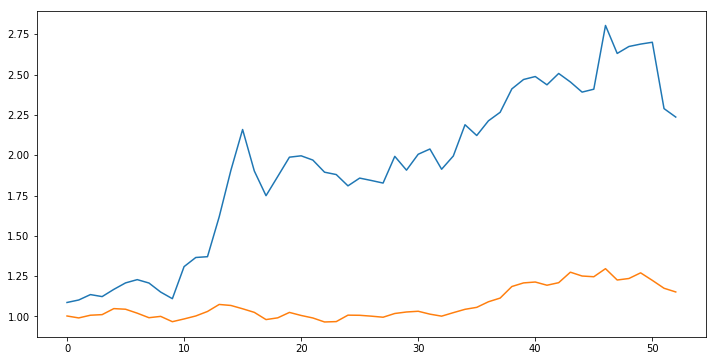

In [57]:
test_cut_rank = 1

returns_m = ohlcv_m.pct_change()
returns_m = returns_m['2014':]

high_rank = None

profit_history = []
benchmark_history = []

for date in range(len(score_rank['2014':]) - 1):
    if type(high_rank) != type(None):
        #  수익률 계산하기
        future_date = date + 1
        profit = returns_m.iloc[future_date][high_rank_index].mean()
        benchmark_profit = returns_m.iloc[future_date]['코스피']
        profit_history.append(profit)
        benchmark_history.append(benchmark_profit)
    row = score_rank['2014':].iloc[date]
    high_rank = row[row <= test_cut_rank]
    high_rank_index = high_rank.index
    
profit_df = pd.DataFrame(profit_history)
profit_df['Benchmark'] = benchmark_history
profit_df['Return + 1'] = profit_df[0] + 1
profit_df['BM Return + 1'] = profit_df['Benchmark'] + 1
profit_df['Excess Return'] = profit_df[0] - profit_df['Benchmark']
sharpe_ratio = profit_df['Excess Return'].mean() / profit_df['Excess Return'].std()

yield_curve = []
bm_yield_curve = []

value = 1
bm_value = 1

for i in range(len(profit_df)):
    value = value * profit_df['Return + 1'][i]
    bm_value = bm_value * profit_df['BM Return + 1'][i]
    yield_curve.append(value)
    bm_yield_curve.append(bm_value)
    
print('Top Rank Stock Numbers: {}'.format(test_cut_rank))
bt_return = (yield_curve[-1] - yield_curve[0]) * 100
annual_retrun = bt_return ** (1/4) - 1
print('Total Returns Over Period: {} %'.format(bt_return))
print('Mean Annual Return: {} %'.format(annual_retrun))
print('Sharpe Ratio: {}'.format(sharpe_ratio))
    
plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(yield_curve)
plt.plot(bm_yield_curve)
plt.show()

Top Rank Stock Numbers: 1
Total Returns Over Period: 114.98863645432746 %
Mean Annual Return: 21.08877239366034 %
Sharpe Ratio: 0.242053968689449


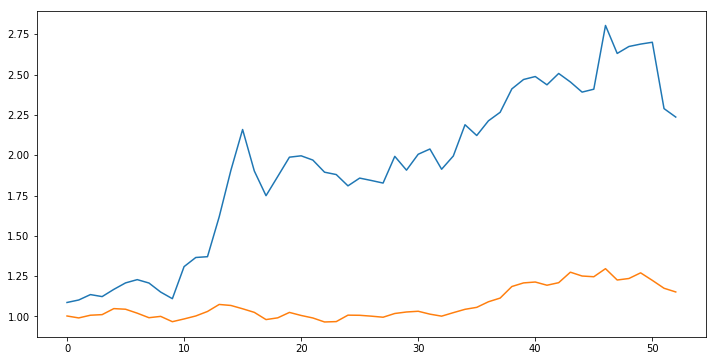

Top Rank Stock Numbers: 5
Total Returns Over Period: 62.590128379380296 %
Mean Annual Return: 12.920695268080662 %
Sharpe Ratio: 0.21019232630489035


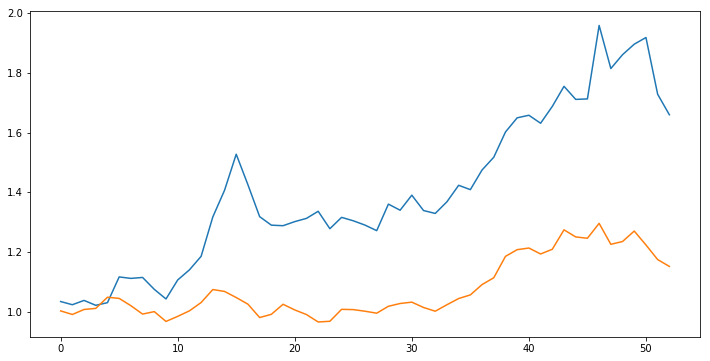

Top Rank Stock Numbers: 10
Total Returns Over Period: 61.15978913209818 %
Mean Annual Return: 12.671525030996067 %
Sharpe Ratio: 0.25642580814487415


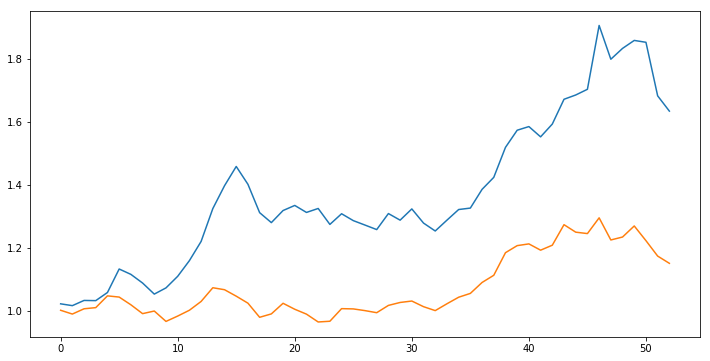

Top Rank Stock Numbers: 25
Total Returns Over Period: 32.45531638095813 %
Mean Annual Return: 7.279650154045658 %
Sharpe Ratio: 0.11897847874980343


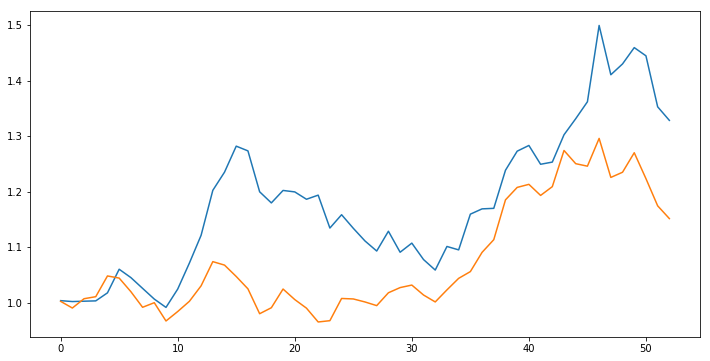

Top Rank Stock Numbers: 50
Total Returns Over Period: 36.03607669169217 %
Mean Annual Return: 7.997455815039767 %
Sharpe Ratio: 0.13924864897009884


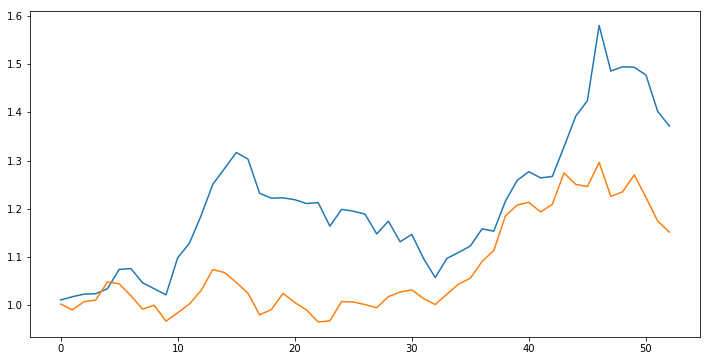

Top Rank Stock Numbers: 100
Total Returns Over Period: 27.096850434331323 %
Mean Annual Return: 6.1777937886768886 %
Sharpe Ratio: 0.08919912977943006


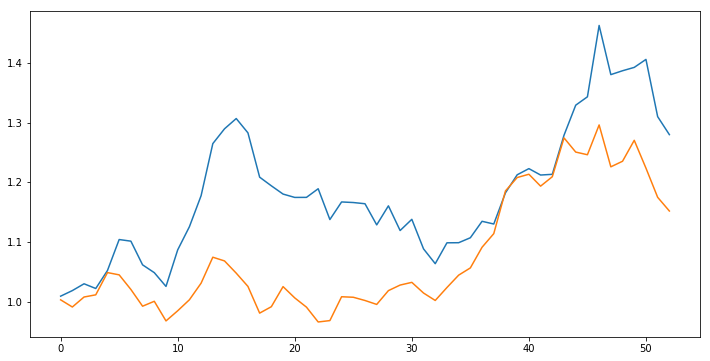

In [63]:
for num in [1, 5, 10, 25, 50, 100]:
    test_cut_rank = num

    returns_m = ohlcv_m.pct_change()
    returns_m = returns_m['2014':]

    high_rank = None

    profit_history = []
    benchmark_history = []

    for date in range(len(score_rank['2014':]) - 1):
        if type(high_rank) != type(None):
            #  수익률 계산하기
            future_date = date + 1
            profit = returns_m.iloc[future_date][high_rank_index].mean()
            benchmark_profit = returns_m.iloc[future_date]['코스피']
            profit_history.append(profit)
            benchmark_history.append(benchmark_profit)
        row = score_rank['2014':].iloc[date]
        high_rank = row[row <= test_cut_rank]
        high_rank_index = high_rank.index

    profit_df = pd.DataFrame(profit_history)
    profit_df['Benchmark'] = benchmark_history
    profit_df['Return + 1'] = profit_df[0] + 1
    profit_df['BM Return + 1'] = profit_df['Benchmark'] + 1
    profit_df['Excess Return'] = profit_df[0] - profit_df['Benchmark']
    sharpe_ratio = profit_df['Excess Return'].mean() / (profit_df['Excess Return'].var() ** (1/2))

    yield_curve = []
    bm_yield_curve = []

    value = 1
    bm_value = 1

    for i in range(len(profit_df)):
        value = value * profit_df['Return + 1'][i]
        bm_value = bm_value * profit_df['BM Return + 1'][i]
        yield_curve.append(value)
        bm_yield_curve.append(bm_value)

    print('Top Rank Stock Numbers: {}'.format(test_cut_rank))
    bt_return = (yield_curve[-1] - yield_curve[0]) * 100
    annual_retrun = ((1 + (yield_curve[-1] - yield_curve[0])) ** (1/4) - 1) * 100
    print('Total Returns Over Period: {} %'.format(bt_return))
    print('Mean Annual Return: {} %'.format(annual_retrun))
    print('Sharpe Ratio: {}'.format(sharpe_ratio))

    plt.rcParams["figure.figsize"] = (12, 6)
    plt.plot(yield_curve)
    plt.plot(bm_yield_curve)
    plt.show()

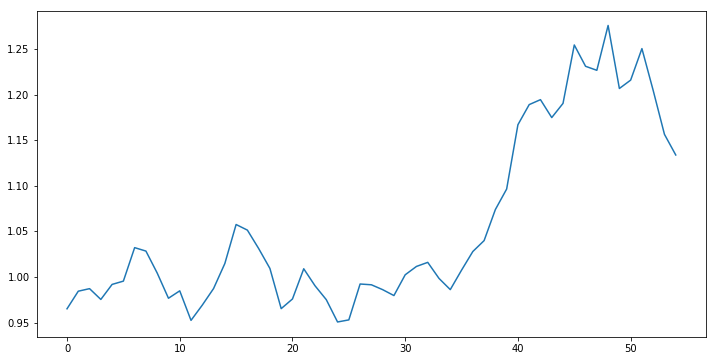

In [53]:
bm = pd.DataFrame(returns_m['코스피']['2014':])
bm['r + 1'] = bm['코스피'] + 1
bm_yield = []
bm_value = 1
for i in range(len(bm)):
    bm_value = bm_value * bm['r + 1'][i]
    bm_yield.append(bm_value)
plt.plot(bm_yield)
plt.show()

In [58]:
bm_yield[-1] - bm_yield[0]

0.16877802857796298

In [60]:
(1 + bm_yield[-1] - bm_yield[0]) ** (1/4) - 1

0.03975976965144046

In [83]:
kp_rank = pd.DataFrame(score_rank['코스피'])
kp_rank['코스피 Rank Scaled'] = (-1 * kp_rank['코스피']) + kp_rank['코스피'].max()
kp_rank_scaled = kp_rank['코스피 Rank Scaled']
bins = np.linspace(kp_rank_scaled.min(), kp_rank_scaled.max(), 100)
kp_signal = pd.DataFrame(np.digitize(kp_rank_scaled, bins))
kp_signal.index = pd.to_datetime(kp_rank_scaled.index)

kp_signal['Rank Long'] = kp_signal.rolling(3).mean().fillna(100)
kp_signal['Signal'] = (kp_signal[0] > kp_signal['Rank Long']) * 1
kp_signal['Signal Price'] = (kp_signal['Signal'] * ohlcv_m['코스피']).replace(0, np.nan)

In [84]:
fee = 0.00015
tax = 0.003

capital = 100000000
stock_num = 0
portfolio_value = 0

capital_history = []

price = ohlcv_m['코스피']

for date in range(len(kp_signal)):
    
    stock_price = price[date]
    buy_price = (stock_price * (1 + fee))
    sell_price = (stock_price * (1 - fee - tax))
    
    signal = kp_signal['Signal'][date]
    
    if signal == 1:
        
        if stock_num == 0:
            # 매수
            buy_num = int(capital // buy_price)
            stock_num += buy_num
            portfolio_value += (buy_num * buy_price)
            capital -= portfolio_value
            
    elif signal == 0:
        
        if stock_num != 0:
            # 매도
            capital += (stock_num * sell_price)
            stock_num = 0
            portfolio_value = 0
            
    total_value = capital + portfolio_value
    capital_history.append(total_value)

Return: 0.29758462313391937


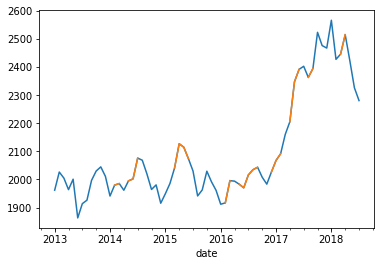

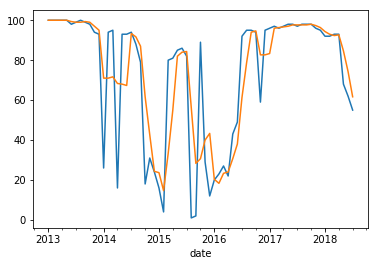

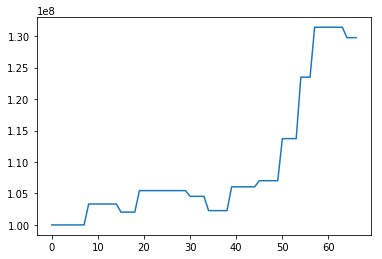

In [86]:
print('Return: {}'.format((capital_history[-1] - capital_history[0]) / capital_history[0]))

ohlcv_m['코스피'].plot()
kp_signal['Signal Price'].plot()
plt.show()

kp_signal[0].plot()
kp_signal['Rank Long'].plot()
plt.show()

plt.plot(capital_history)
plt.show()